In [ ]:
%load_ext nb_black

# 0. Initiate

In [25]:
# Load packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import scipy as sp
from scipy.io.wavfile import write
from tqdm import tqdm
import librosa
import librosa.display
import math

import warnings
warnings.simplefilter(action="ignore")

from HumBugDB.LogMelSpecs.compute_LogMelSpecs import waveform_to_examples
from DataProcessing.XGBoost_features.metadata import *
from DataProcessing.helper_code import *
from DataProcessing.find_and_load_patient_files import *
from DataProcessing.label_extraction import *

In [26]:
# Define paths
data_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/physionet.org/files/circor-heart-sound/1.0.3/training_data"
output_folder = "data/challenge_anaylsis/"

In [27]:
def get_features(data, recordings):
    # Extract the age group and replace with the (approximate) number of months for the middle of the age group.
    age_group = get_age(data)

    if compare_strings(age_group, 'Neonate'):
        age = 0.5
    elif compare_strings(age_group, 'Infant'):
        age = 6
    elif compare_strings(age_group, 'Child'):
        age = 6 * 12
    elif compare_strings(age_group, 'Adolescent'):
        age = 15 * 12
    elif compare_strings(age_group, 'Young Adult'):
        age = 20 * 12
    else:
        age = float('nan')

    # Extract sex. Use one-hot encoding.
    sex = get_sex(data)

    sex_features = np.zeros(2, dtype=int)
    if compare_strings(sex, 'Female'):
        sex_features[0] = 1
    elif compare_strings(sex, 'Male'):
        sex_features[1] = 1

    # Extract height and weight.
    height = get_height(data)
    weight = get_weight(data)

    # Extract pregnancy status.
    is_pregnant = get_pregnancy_status(data)

    # Extract recording locations and data. Identify when a location is present, and compute the mean, variance, and skewness of
    # each recording. If there are multiple recordings for one location, then extract features from the last recording.
    locations = get_locations(data)

    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
    num_recording_locations = len(recording_locations)
    recording_features = np.zeros((num_recording_locations, 4), dtype=float)
    num_locations = len(locations)
    num_recordings = len(recordings)
    if num_locations==num_recordings:
        for i in range(num_locations):
            for j in range(num_recording_locations):
                if compare_strings(locations[i], recording_locations[j]) and np.size(recordings[i])>0:
                    recording_features[j, 0] = 1
                    recording_features[j, 1] = np.mean(recordings[i])
                    recording_features[j, 2] = np.var(recordings[i])
                    recording_features[j, 3] = sp.stats.skew(recordings[i])
    recording_features = recording_features.flatten()

    features = np.hstack(([age_group], [age], sex_features, [height], [weight], [is_pregnant], recording_features))

    return np.asarray(features)

In [28]:
# Load recordings.
def load_recordings(data_folder, data, get_frequencies=False):
    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    recordings = list()
    locations = list()
    frequencies = list()
    for i in range(num_locations):
        entries = recording_information[i].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)
        recording, frequency = load_wav_file(filename)
        recordings.append(recording)
        locations.append(entries[0])
        frequencies.append(frequency)

    if get_frequencies:
        return recordings, locations, frequencies
    else:
        return recordings, locations

# 1. Load data

In [29]:
 # Find the patient data files.
patient_files = find_patient_files(data_folder)
num_patient_files = len(patient_files)

murmur_classes = ['Present', 'Unknown', 'Absent']
num_murmur_classes = len(murmur_classes)
outcome_classes = ['Abnormal', 'Normal']
num_outcome_classes = len(outcome_classes)
features = list()
murmurs = list()
outcomes = list()
recordings = list()
locations = list()
print("Extracting features from patient data...")
for i in tqdm(range(num_patient_files)):

    # Load the current patient data and recordings.
    current_patient_data = load_patient_data(patient_files[i])
    current_recordings, current_locations = load_recordings(data_folder, current_patient_data)
    current_recordings = [r / 32768 for r in current_recordings]
    num_recordings_code = get_num_locations(current_patient_data)
    num_recordings = len(current_recordings)
    recordings.append(current_recordings)
    locations.append(current_locations)

    # Extract features.
    current_features = get_features(current_patient_data, current_recordings)
    current_features = np.insert(current_features,0,current_patient_data.split(" ")[0])
    current_features = np.insert(current_features,1,current_patient_data.split(" ")[2][:-3])
    current_features = np.insert(current_features,2,num_recordings)
    current_features = np.insert(current_features,3,num_recordings_code)
    features.append(current_features)

    # Extract labels and use one-hot encoding.
    ## Murmur
    current_murmur = np.zeros(num_murmur_classes, dtype=int)
    murmur = get_murmur(current_patient_data)
    if murmur in murmur_classes:
        j = murmur_classes.index(murmur)
        current_murmur[j] = 1
    murmurs.append(current_murmur)
    ## Outcome
    current_outcome = np.zeros(num_outcome_classes, dtype=int)
    outcome = get_outcome(current_patient_data)
    if outcome in outcome_classes:
        j = outcome_classes.index(outcome)
        current_outcome[j] = 1
    outcomes.append(current_outcome)

features = np.vstack(features)
murmurs = np.vstack(murmurs)
outcomes = np.vstack(outcomes)

# Combine dataframes
print("Combining dataframes...")
assert len(recordings) == len(locations)
features_pd = pd.DataFrame(features, columns=["id", "hz", "num_recordings", "num_recordings_code", "age_group", "age", "female", "male", "height", "weight", "is_pregnant"]+[f"standard_recording_features_{i}_{t}" for t in ["1", "mean", "var", "skew"] for i in range(5)])#+[f"signatures{i}" for i in range(len(features[0])-12)])
murmurs_pd = pd.DataFrame(murmurs, columns=murmur_classes)
outcomes_pd = pd.DataFrame(outcomes, columns=outcome_classes)
recordings_pd = pd.DataFrame(columns=np.unique([item for sublist in locations for item in sublist]))
for i in tqdm(range(len(locations))):
    dict_data = {locations[i][j]: [recordings[i][j]] for j in range(len(locations[i]))}
    temp_df = pd.DataFrame(dict_data)
    recordings_pd = pd.concat([recordings_pd, temp_df], ignore_index=True)
complete_pd = pd.concat([features_pd.loc[:, [c for c in features_pd.columns if "standard_recording_features_" not in c]], murmurs_pd, outcomes_pd, recordings_pd], axis=1)

# Prep
features_pd["age_year"] = features_pd['age'].astype(float).astype(int, errors='ignore')/12
complete_pd["age_year"] = complete_pd['age'].astype(float).astype(int, errors='ignore')/12
complete_pd["murmur"]= [1 if p==1 else -1 if a==1 else 0 for p,a  in zip(complete_pd.Present, complete_pd.Absent)]
complete_pd["is_pregnant"] = complete_pd["is_pregnant"].apply(lambda x: 0 if x=="False" else 1)

# Get recordings length
for c in complete_pd.columns:
    if "location" in c and "length" not in c:
        complete_pd[c].loc[complete_pd[c].isnull()] = complete_pd[c].loc[complete_pd[c].isnull()].apply(lambda x: [])
        complete_pd[f"length_sec_{c}"] = complete_pd[c].apply(len)/complete_pd['hz'].astype(float).astype("Int64")

# Label nans correctly
complete_pd = complete_pd.replace("nan", np.nan)

# Convert columns
complete_pd["age"] = complete_pd["age"].astype(float)
complete_pd["height"] = complete_pd["height"].astype(float)
complete_pd["weight"] = complete_pd["weight"].astype(float)
complete_pd["age_year"] = complete_pd["age_year"].astype(float)
complete_pd["age_group"] = complete_pd["age_group"].fillna("Unknown")

Extracting features from patient data...


100%|██████████| 942/942 [00:03<00:00, 286.02it/s]


Combining dataframes...


100%|██████████| 942/942 [00:00<00:00, 3009.49it/s]


In [30]:
# Save df
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
complete_pd[['id', 'hz', 'num_recordings', 'num_recordings_code', 'age_group', 'age', 'female',
       'male', 'height', 'weight', 'is_pregnant', 'Present', 'Unknown',
       'Absent', 'Abnormal', 'Normal', 'age_year',
       'murmur']].to_csv(f"{output_folder}complete_pd.csv", index=False)

# 2. Data distributions

In [31]:
# Descriptive
pd.DataFrame(complete_pd.describe())

,age,height,weight,is_pregnant,Present,Unknown,Absent,Abnormal,Normal,age_year,murmur
count,868.000000,826.000000,837.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,868.000000,942.000000
mean,70.883641,110.800242,23.632756,0.074310,0.190021,0.072187,0.737792,0.484076,0.515924,5.906970,-0.547771
std,40.445269,30.000607,15.453337,0.262414,0.392526,0.258934,0.440069,0.500012,0.500012,3.370439,0.792734
min,0.500000,35.000000,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,-1.000000
25%,72.000000,89.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,-1.000000
50%,72.000000,115.000000,20.400000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,6.000000,-1.000000
75%,72.000000,133.000000,31.200000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,6.000000,0.000000
max,180.000000,180.000000,110.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


In [ ]:
# Missing values
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(complete_pd[['age', 'female', 'male', 'height', 'weight', 'is_pregnant', 'murmur']].astype(float).isna(), cbar=False, cmap="Greys", ax=ax)
plt.xticks(fontsize=12, rotation=0)
ax.set_yticks([])

In [ ]:
# Missing values if age is missing
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(complete_pd.loc[complete_pd.age.isnull(),:].isnull(), cbar=False, cmap="Greys", ax=ax)

In [ ]:
# Weight
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(complete_pd.weight.astype(float), bins=20)

In [ ]:
# Height
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(complete_pd["height"].astype(float), bins=20)

In [ ]:
complete_pd["age_group"].unique()

In [ ]:
# Height, weight
fig, ax = plt.subplots(figsize=(20,14))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 20
sns.scatterplot(x="weight", y="height", hue="age_group", data=complete_pd, hue_order=['Unknown', 'Adolescent', 'Child', 'Infant', 'Neonate'], s=120)
ax.set(xlabel='Weight [kg]', ylabel='Height [cm]')

In [ ]:
# Height, weight
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x="weight", y="height", hue="female", data=complete_pd)

In [ ]:
# Age
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(complete_pd.age_year, bins=50)

In [ ]:
# Labels
pd.crosstab([complete_pd.Abnormal, complete_pd.Normal], [complete_pd.Present, complete_pd.Unknown, complete_pd.Absent, complete_pd.murmur])

# 3. Recordings

In [ ]:
location_names = ["AV", "MV", "PV", "Phc", "TV"]
dic_aux = {}
for l in location_names:
    dic_aux[l] = [0 if isinstance(v, float) else len(v)/4000 for v in complete_pd[l]]
df_lengths = pd.DataFrame({"length_sec": [item for sublist in dic_aux.values() for item in sublist], "murmur": list(complete_pd.murmur)*len(location_names)})
df_lengths["length_sec"] = df_lengths["length_sec"].astype(float)

In [ ]:
# Length
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.histplot(df_lengths, x="length_sec", hue="murmur", ax=ax, stat="count", bins=[0,5,10,15,20,25,30,35,40,50,60,70])

In [ ]:
# Num recordings
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.histplot(complete_pd, x="num_recordings", hue="murmur", ax=ax, stat="count", binrange=[0,6], binwidth=1)

# 4. Pascal data

In [1]:
# Define folders
normal_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pascal/Training B Normal"
murmur_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pascal/Btraining_murmur"
extrastole_folder = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pascal/Btraining_extrastole/"
output_folder_pascal = "/Users/felixkrones/python_projects/data/physionet_challenge_2022/pascal/"

In [3]:
# Get all paths
normal_paths = [os.path.join(normal_folder, f) for f in os.listdir(normal_folder) if ".wav" in f]
murmur_paths = [os.path.join(murmur_folder, f) for f in os.listdir(murmur_folder) if ".wav" in f]
extrastole_paths = [os.path.join(extrastole_folder, f) for f in os.listdir(extrastole_folder) if ".wav" in f]

In [4]:
# Combine in dataframe
df_pascal = pd.DataFrame({"path": normal_paths + murmur_paths + extrastole_paths, "label": ["normal"]*len(normal_paths) + ["murmur"]*len(murmur_paths) + ["extrastole"]*len(extrastole_paths)})
df_pascal["rec_length"] = np.nan
df_pascal["frequency"] = np.nan
df_pascal["rec_duration_sec"] = np.nan
df_pascal["recording"] = np.nan
df_pascal["recording"] = df_pascal["recording"].astype(object)
for i in range(len(df_pascal)):
    recording, frequency = load_wav_file(df_pascal.path.iloc[i])
    df_pascal["rec_length"].iloc[i] = len(recording)
    df_pascal["frequency"].iloc[i] = frequency
    df_pascal["rec_duration_sec"].iloc[i] = len(recording)/frequency
    df_pascal["recording"].iloc[i] = recording

# Save df
df_pascal.to_csv(f"{output_folder_pascal}df_pascal.csv", index=False)

In [5]:
df_pascal.head(2)

,path,label,rec_length,frequency,rec_duration_sec,recording
0,/Users/felixkrones/python_projects/data/physio...,normal,6497.0,4000.0,1.62425,"[-98, 214, 283, 254, 423, 778, 669, 432, 546, ..."
1,/Users/felixkrones/python_projects/data/physio...,normal,8199.0,4000.0,2.04975,"[-935, -919, -777, -513, -95, 23, -57, 20, 117..."


In [6]:
# Distribution of labels
pd.crosstab([df_pascal.label], [df_pascal.label])

label,extrastole,murmur,normal
label,,,
extrastole,46,0,0
murmur,0,66,0
normal,0,0,200


[Text(0.5, 0, 'Recording duration [sec]')]

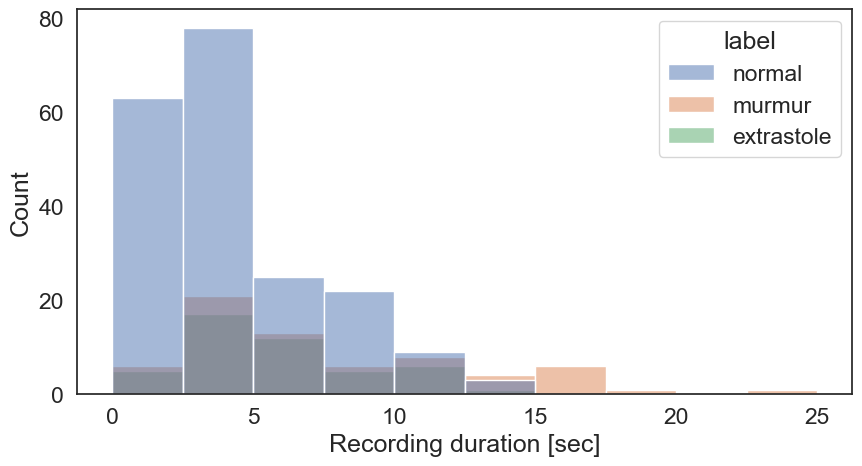

In [17]:
# Length
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['font.size'] = 15
sns.histplot(df_pascal, x="rec_duration_sec", hue="label", ax=ax, stat="count", bins=[0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,25])
ax.set(xlabel='Recording duration [sec]')

In [20]:
df_pascal[df_pascal.label=="extrastole"].rec_duration_sec.describe()

count    46.000000
mean      5.858043
std       3.126281
min       1.874500
25%       3.604875
50%       5.153750
75%       7.717125
max      13.380750
Name: rec_duration_sec, dtype: float64

In [24]:
print(np.max([np.max(i) for i in df_pascal.recording]))
print(np.min([np.min(i) for i in df_pascal.recording]))

32767
-32768
